In [1477]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score

df = pd.read_excel('./activity_sample.xlsx')

In [1448]:
df = df.drop('Unnamed: 0', axis = 1)

In [1449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6476 entries, 0 to 6475
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   userid               6476 non-null   object        
 1   learning_seq         6476 non-null   int64         
 2   mcode                6476 non-null   object        
 3   learning_action_seq  6476 non-null   int64         
 4   event_type           6476 non-null   object        
 5   action               6476 non-null   object        
 6   object_type          6476 non-null   object        
 7   timestamp            6476 non-null   datetime64[ns]
 8   gender               6476 non-null   object        
 9   grade                6476 non-null   int64         
 10  memberstatus         6476 non-null   int64         
 11  memberstatus_change  6476 non-null   object        
 12  day_01_status        6476 non-null   object        
 13  day_02_status        6476 non-nul

| features | 정보 |
| --- | --- |
| userid | 사용자 id |
| learning_seq | 학습 순서 |
| mcode | 콘텐츠 고유 id |
| learning_action_seq | 학습 중 행동 순서 |
| event_type | 이벤트 유형 |
| action | 이벤트에 포함되는 행동 내용 |
| object_type | 활동 대상 |
| timestamp | 해당 학습 중 행동이 발생한 시간 |
| gender | 사용자의 성별 |
| grade | 사용자의 학년 |
| memberstatus | 회원 상태(정회원, 준회원, 탈퇴회원 등) |
| memberstatus_change | 월 중 회원 상태 변화 |
| 'day_01_status' ~ 'day_31_status' | 1일 ~ 31일 회원 상태 |
| change_date | 회원 상태 변화까지 걸린 시간 |

In [1450]:
le = LabelEncoder()
df['userid_encoded'] = le.fit_transform(df['userid'])
df['mcode_encoded'] = le.fit_transform(df['mcode'])
df['object_type_encoded'] = le.fit_transform(df['object_type'])
# df['action_encoded'] = le.fit_transform(df['action'])

In [1451]:
df[['mcode_encoded', 'mcode']].value_counts()

mcode_encoded  mcode       
128            T0SE52U09001    283
21             T0KE52U02003    265
25             T0KE52U02007    190
105            T0NE52U11002    184
1              T0EE52U02002    183
                              ... 
72             T0ME52U22038      1
60             T0ME52U21014      1
164            T0WE90U01016      1
163            T0WE90U01002      1
196            T9EE52U75001      1
Name: count, Length: 205, dtype: int64

In [1452]:
df[['object_type_encoded','object_type']].value_counts()

object_type_encoded  object_type    
1                    VideoObject        3631
0                    DigitalResource    2844
2                    WebPage               1
Name: count, dtype: int64

In [1453]:
df['userid_encoded'].value_counts()

userid_encoded
25    782
18    571
5     432
29    410
22    389
12    324
10    323
11    312
1     306
4     306
9     285
21    202
16    198
15    192
24    183
13    179
7     167
2     167
6     161
20    144
3     103
26     92
23     89
0      46
8      42
17     35
14     17
19     15
28      3
27      1
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


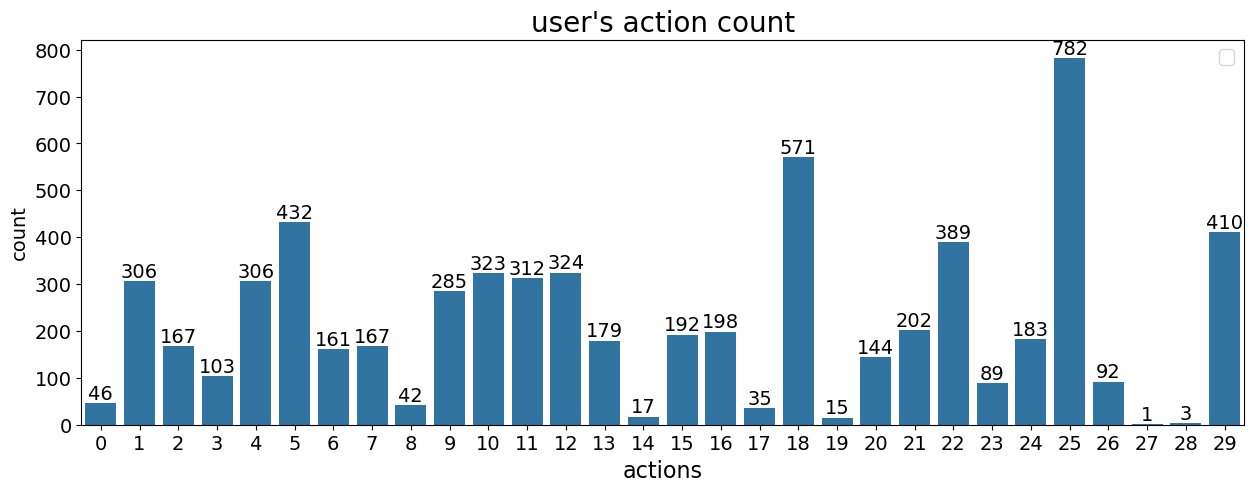

In [1454]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x = df['userid_encoded'])
plt.title("user's action count", fontsize = 20)
plt.xlabel("actions", fontsize=16)
plt.ylabel("count", fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)  # x축 눈금 글자 크기
plt.yticks(fontsize=14)  # y축 눈금 글자 크기
for p in ax.patches:
    # p.patches는 각 막대의 패치 객체를 포함합니다.
    height = p.get_height()  # 막대의 높이
    ax.text(p.get_x() + p.get_width() / 2, height, f'{int(height)}', 
            ha='center', va='bottom', fontsize=14, color='black')

In [1455]:
pre = pd.DataFrame(df.loc[(df['userid_encoded'] == 25)].sort_values(['timestamp','learning_action_seq']).reset_index())

In [1456]:
pre['action']

0           Viewed
1      NavigatedTo
2           Viewed
3      NavigatedTo
4           Viewed
          ...     
777       JumpedTo
778          Ended
779         Viewed
780    NavigatedTo
781         Viewed
Name: action, Length: 782, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


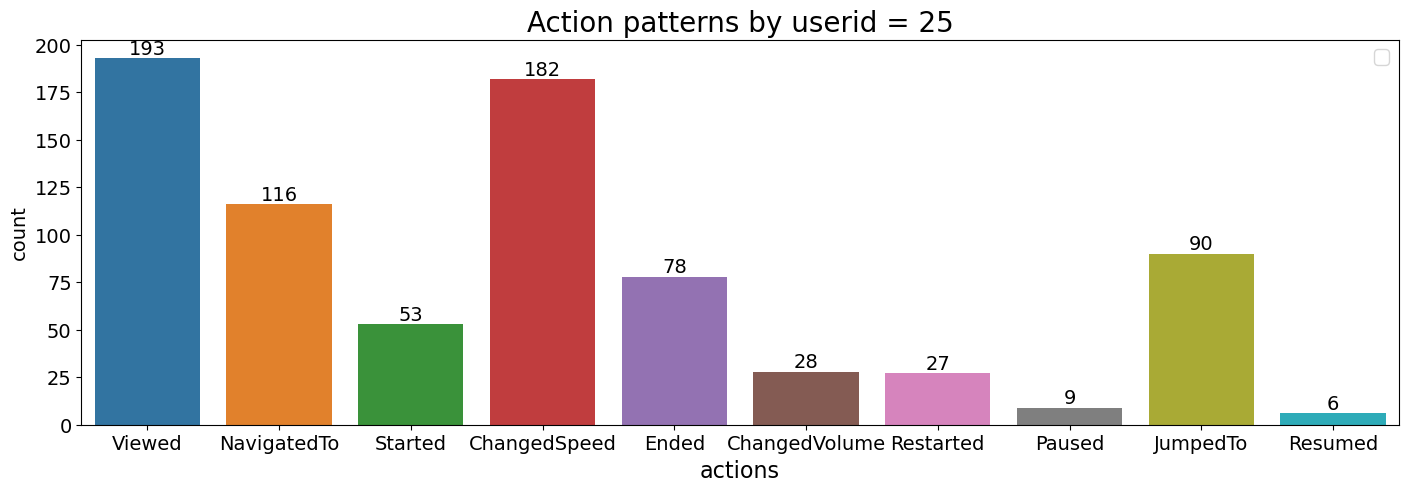

In [1457]:
plt.figure(figsize=(17,5))
ax = sns.countplot(x=pre['action'], hue=pre['action'])
plt.title("Action patterns by userid = 25", fontsize = 20)
plt.xlabel("actions", fontsize=16)
plt.ylabel("count", fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)  # x축 눈금 글자 크기
plt.yticks(fontsize=14)  # y축 눈금 글자 크기
for p in ax.patches:
    # p.patches는 각 막대의 패치 객체를 포함합니다.
    height = p.get_height()  # 막대의 높이
    ax.text(p.get_x() + p.get_width() / 2, height, f'{int(height)}', 
            ha='center', va='bottom', fontsize=14, color='black')


In [1458]:
X = pd.DataFrame(df.loc[df['userid_encoded'] == 18,['mcode_encoded','learning_seq','learning_action_seq','object_type_encoded','timestamp']].sort_values(['timestamp','learning_action_seq']))
X

,mcode_encoded,learning_seq,learning_action_seq,object_type_encoded,timestamp
3595,131,1,1,0,2022-09-01 16:18:23.661
3596,131,1,2,0,2022-09-01 16:18:32.892
3597,131,1,3,0,2022-09-01 16:18:33.062
3598,83,5,1,1,2022-09-01 16:51:47.826
3599,83,5,2,1,2022-09-01 16:54:59.300
...,...,...,...,...,...
4161,96,11,18,0,2022-09-20 22:56:20.295
4162,97,12,1,1,2022-09-20 22:57:46.588
4163,97,12,2,1,2022-09-20 22:58:03.832
4164,97,12,3,1,2022-09-20 22:58:06.392


In [1459]:
features = [
    'learning_seq', 'learning_action_seq', 'mcode_encoded', 'object_type_encoded'
]

In [1460]:
y = df.loc[df['userid_encoded'] == 18,['object_type_encoded','action','timestamp','learning_action_seq']].sort_values(['timestamp','learning_action_seq'])
y

,object_type_encoded,action,timestamp,learning_action_seq
3595,0,Viewed,2022-09-01 16:18:23.661,1
3596,0,NavigatedTo,2022-09-01 16:18:32.892,2
3597,0,Viewed,2022-09-01 16:18:33.062,3
3598,1,Started,2022-09-01 16:51:47.826,1
3599,1,Paused,2022-09-01 16:54:59.300,2
...,...,...,...,...
4161,0,NavigatedTo,2022-09-20 22:56:20.295,18
4162,1,Started,2022-09-20 22:57:46.588,1
4163,1,JumpedTo,2022-09-20 22:58:03.832,2
4164,1,JumpedTo,2022-09-20 22:58:06.392,3


In [1461]:
# X_train, X_test, y_train, y_test = train_test_split(X[features],y['action'],test_size=0.2, random_state=12345)

In [1462]:
split_index = int(len(X) * 0.8)  # 80%를 훈련 데이터로 사용

X_train = X.iloc[:split_index,[0,1,2,3]]
y_train = y.iloc[:split_index,1]
X_test = X.iloc[split_index:,[0,1,2,3]]
y_test = y.iloc[split_index:,1]

In [1463]:
models = {
    'rfm' : RandomForestClassifier(n_estimators=1000, random_state=12345),
    'lr' :  LogisticRegression(random_state=12345),
    'gb' : GradientBoostingClassifier(n_estimators=1000, random_state=12345),
    'svm' : SVC(probability=True, random_state=12345), # 확률 예측을 위해 probability = True
    'knn' : KNeighborsClassifier()
}

# 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

# 결과 출력
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print(results_df)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model  Accuracy
0   rfm  0.547826
1    lr  0.321739
2    gb  0.513043
3   svm  0.243478
4   knn  0.365217


In [1464]:
voting_clf_soft = VotingClassifier(estimators=[
    ('rfm', models['rfm']),
    ('lr', models['lr']),
    ('gb', models['gb']),
    ('svm', models['svm']),
    ('knn', models['knn'])
], voting='soft')

# 모델 학습 및 평가
voting_clf_soft.fit(X_train, y_train)
y_pred = voting_clf_soft.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Soft Voting Classifier Accuracy: {accuracy:.4f}")

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Soft Voting Classifier Accuracy: 0.5217


In [1465]:
# model = GradientBoostingClassifier(n_estimators=100, random_state=12345)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test,y_pred)
# accuracy

In [1466]:
voting_clf_soft.score(X_train, y_train)

1.0

In [1467]:
cm = confusion_matrix(y_test, y_pred)

In [1468]:
label_order = [
    'ChangedSpeed','ChangedVolume','Ended','JumpedTo','NavigatedTo','Paused','Restarted','Started','Viewed'
    ]

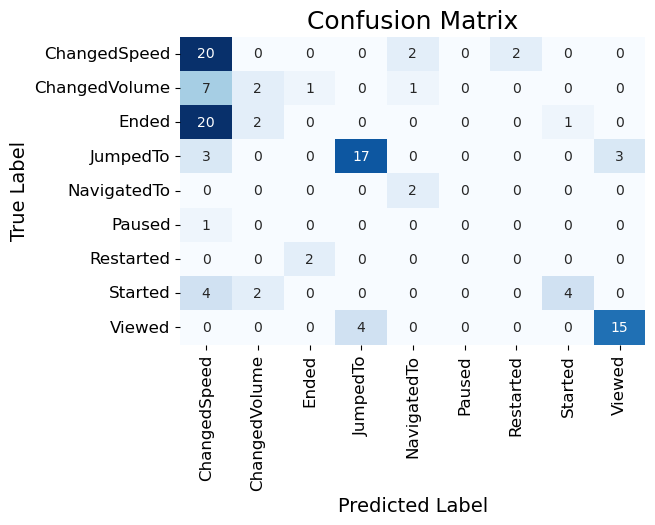

In [1469]:
# 혼동 행렬
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_order, yticklabels=label_order)
plt.title('Confusion Matrix', fontsize = 18)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize= 14)
plt.xticks(fontsize=12)  # x축 눈금 글자 크기
plt.yticks(fontsize=12)  # y축 눈금 글자 크기
plt.show()

In [1470]:
le.classes_

array(['DigitalResource', 'VideoObject', 'WebPage'], dtype=object)

In [1471]:
list(y_pred).count('Started')

5

In [1472]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns={0 : 'predicted'})
y_pred_df['truth'] = y_test.values
y_pred_df['bool'] = y_pred_df['truth'] == y_pred_df['predicted']
y_pred_df

,predicted,truth,bool
0,NavigatedTo,NavigatedTo,True
1,Viewed,Viewed,True
2,Viewed,Viewed,True
3,NavigatedTo,NavigatedTo,True
4,Viewed,Viewed,True
...,...,...,...
110,NavigatedTo,NavigatedTo,True
111,Started,Started,True
112,ChangedSpeed,JumpedTo,False
113,ChangedSpeed,JumpedTo,False


AttributeError: 'float' object has no attribute 'round'

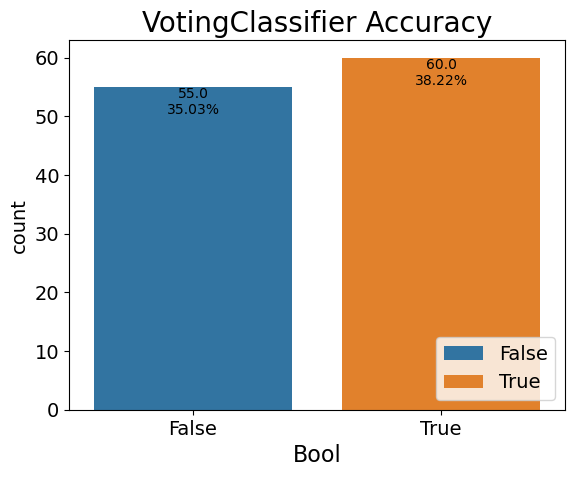

In [1473]:
ax = sns.countplot(x = y_pred_df['bool'], hue=y_pred_df['bool'])

plt.title("VotingClassifier Accuracy", fontsize = 20)
plt.xlabel("Bool", fontsize=16)
plt.ylabel("count", fontsize=14)
plt.legend(loc = 'lower right', fontsize=14)
plt.xticks(fontsize=14)  # x축 눈금 글자 크기
plt.yticks(fontsize=14)  # y축 눈금 글자 크기
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}\n{(height / 157 * 100).round(2)}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', 
                va='top')

In [1474]:
y_pred_prob = voting_clf_soft.predict_proba(X_test)[:, 1]
y_pred_prob.round(2) * 100

array([ 1.,  1.,  5.,  5.,  4.,  7., 12., 12., 10.,  7.,  7.,  3.,  3.,
        3.,  1.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,  5.,  6.,
        7., 10.,  9.,  6.,  6.,  6.,  6.,  1.,  2.,  2.,  2.,  1.,  1.,
        1.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  3.,  3.,  4.,  4.,  4., 12., 16., 21., 21.,
       16.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  3.,  3.,  2.,  2.,
        2.,  2.,  2.,  2.,  1.,  1.,  1.,  3.,  3.,  3.,  3.])

c:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


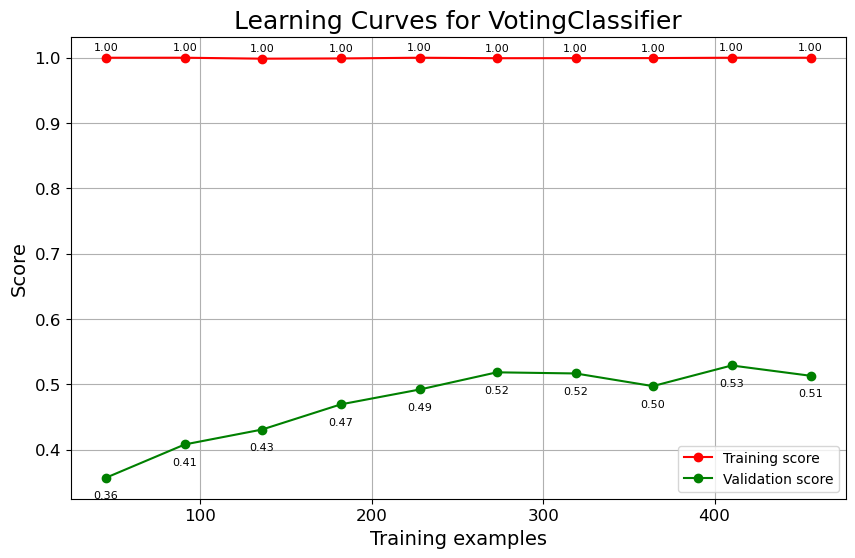

In [1475]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title="Learning Curves"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1, 10)
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation score')
    for i in range(len(train_sizes)):
        plt.annotate(f'{train_scores_mean[i]:.2f}', 
                     (train_sizes[i], train_scores_mean[i]), 
                     textcoords="offset points", 
                     xytext=(0,5), 
                     ha='center', 
                     fontsize=8)
        plt.annotate(f'{test_scores_mean[i]:.2f}', 
                     (train_sizes[i], test_scores_mean[i]), 
                     textcoords="offset points", 
                     xytext=(0,-15), 
                     ha='center', 
                     fontsize=8)
    plt.title(title, fontsize = 18)
    plt.xlabel('Training examples', fontsize =14)
    plt.ylabel('Score', fontsize = 14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(fontsize=12)  # x축 눈금 글자 크기
    plt.yticks(fontsize=12)  # y축 눈금 글자 크기
    plt.show()

plot_learning_curve(voting_clf_soft, X[features], y['action'], title="Learning Curves for VotingClassifier")

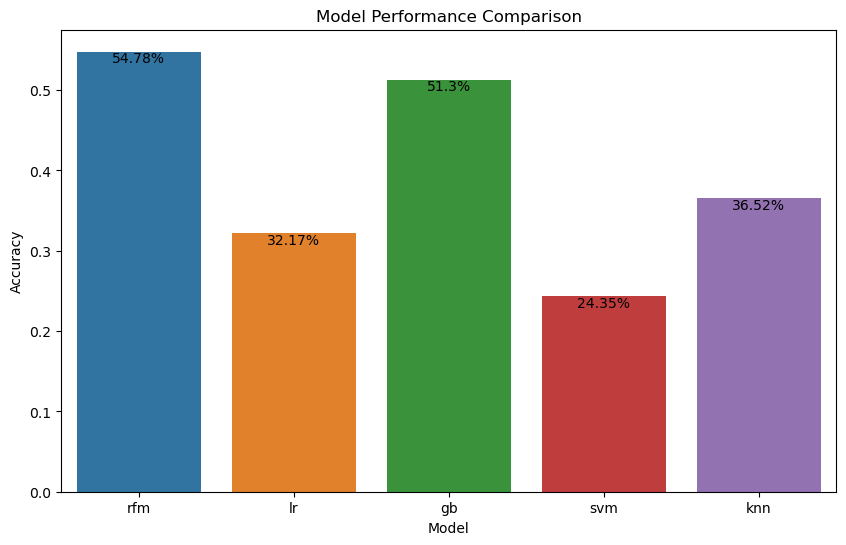

In [1476]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = results.keys(),y = results.values(), hue=results.keys())
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{(height*100).round(2)}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', 
                va='top')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()